In [52]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import sys

src_dir = '../../src/'
if src_dir not in sys.path:
    sys.path.append(src_dir)

from metrics import calculate_conf, calculate_conf_all_samples, compute_f2

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from PIL import Image

from icevision.all import *

In [55]:
DATA_DIR = '../../../data'

In [56]:
df = pd.read_csv(f'{DATA_DIR}/train.csv')

# Process the annotations column
df['annotations'] = df['annotations'].map(eval)
df['num_annotations'] = df['annotations'].map(len)

In [57]:
width, height = [], []

for o in df.itertuples():
    video_id = o.video_id
    video_frame = o.video_frame
    
    img = Image.open(f'{DATA_DIR}/train_images/video_{video_id}/{video_frame}.jpg')
    img_width, img_height = img.size
    
    width.append(img_width)
    height.append(img_height)
    
    img.close()

In [58]:
df['img_width'] = width
df['img_height'] = height

In [59]:
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   num_annotations  img_width  img_height  
0                0       1280         720  
1                0       1280         720  
2                0       1280         720  
3                0       1280         720  
4                0       1280         720

In [60]:
print(f"Negative image examples: {df[df['num_annotations'] == 0].shape[0]}")
print(f"Positive image examples: {df[df['num_annotations'] != 0].shape[0]}")

Negative image examples: 18582
Positive image examples: 4919


In [61]:
sequences = df.groupby(['video_id','sequence']).count().reset_index()[['video_id','sequence']]
train_sequences, valid_sequences = train_test_split(sequences, test_size=0.2, random_state=44, stratify=sequences['video_id'].values)

train_sequences = train_sequences['sequence'].values
valid_sequences = valid_sequences['sequence'].values

df['train_valid'] = df['sequence'].map(lambda x: 'train' if x in train_sequences else 'valid')

df[df['num_annotations']!=0].groupby(['train_valid', 'video_id']).agg({'sequence': 'count'}) / df[df['num_annotations']!=0].shape[0]

sequence
train_valid video_id          
train       0         0.263062
            1         0.412279
            2         0.131734
valid       0         0.172596
            1         0.014434
            2         0.005896

In [62]:
df[df['num_annotations']!=0].groupby(['train_valid']).agg({'sequence': 'count'}) / df[df['num_annotations']!=0].shape[0]

sequence
train_valid          
train        0.807075
valid        0.192925

In [63]:
df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   num_annotations  img_width  img_height train_valid  
0                0       1280         720       valid  
1                0       1280         720       valid  
2                0       1280         720       valid  
3                0       1280         720       valid  
4                0       1280         720       valid

In [64]:
df['annot_g0'] = df['num_annotations'] > 0

In [65]:
df.groupby(['train_valid', 'annot_g0']).count()

video_id  sequence  video_frame  sequence_frame  \
train_valid annot_g0                                                    
train       False        16032     16032        16032           16032   
            True          3970      3970         3970            3970   
valid       False         2550      2550         2550            2550   
            True           949       949          949             949   

                      image_id  annotations  num_annotations  img_width  \
train_valid annot_g0                                                      
train       False        16032        16032            16032      16032   
            True          3970         3970             3970       3970   
valid       False         2550         2550             2550       2550   
            True           949          949              949        949   

                      img_height  
train_valid annot_g0              
train       False          16032  
            True            3970  
valid       False           2550  
            True             949

In [66]:
df.head()

video_id  sequence  video_frame  sequence_frame image_id  ...  \
0         0     40258            0               0      0-0  ...   
1         0     40258            1               1      0-1  ...   
2         0     40258            2               2      0-2  ...   
3         0     40258            3               3      0-3  ...   
4         0     40258            4               4      0-4  ...   

  num_annotations  img_width  img_height  train_valid annot_g0  
0               0       1280         720        valid    False  
1               0       1280         720        valid    False  
2               0       1280         720        valid    False  
3               0       1280         720        valid    False  
4               0       1280         720        valid    False  

[5 rows x 11 columns]

In [67]:
# sequences = df['sequence'].unique()
# train_sequences, valid_sequences = train_test_split(sequences, test_size=0.2, random_state=41, stratify=df['video_id'])

# df['train_valid'] = df['sequence'].map(lambda x: 'train' if x in train_sequences else 'valid')

# df[df['num_annotations']!=0].groupby(['train_valid']).agg({'sequence': 'count'}) / df[df['num_annotations']!=0].shape[0]

# df[df['num_annotations']!=0].groupby(['train_valid', 'video_id']).agg({'sequence': 'count'}) / df[df['num_annotations']!=0].shape[0]

In [68]:
dfexp = df.explode('annotations')

In [69]:
def extract_bb(annot):
    output = {}
    # Extract BB if it's not a negative example
    if not pd.isnull(annot):
        output['xmin'] = annot['x']
        output['ymin'] = annot['y']
        output['bb_width'] = annot['width']
        output['bb_height'] = annot['height']
        
    # otherwise set default values
    else:
        output['xmin'] = -1
        output['ymin'] = -1
        output['bb_width'] = -1
        output['bb_height'] = -1
    
    return output

dfexp['annotations'] = dfexp['annotations'].map(extract_bb)

dfexp['xmin'] = dfexp['annotations'].map(lambda x: x['xmin'])
dfexp['ymin'] = dfexp['annotations'].map(lambda x: x['ymin'])
dfexp['bb_width'] = dfexp['annotations'].map(lambda x: x['bb_width'])
dfexp['bb_height'] = dfexp['annotations'].map(lambda x: x['bb_height'])

dfexp.head()

video_id  sequence  video_frame  sequence_frame image_id  ... annot_g0  \
0         0     40258            0               0      0-0  ...    False   
1         0     40258            1               1      0-1  ...    False   
2         0     40258            2               2      0-2  ...    False   
3         0     40258            3               3      0-3  ...    False   
4         0     40258            4               4      0-4  ...    False   

   xmin  ymin  bb_width bb_height  
0    -1    -1        -1        -1  
1    -1    -1        -1        -1  
2    -1    -1        -1        -1  
3    -1    -1        -1        -1  
4    -1    -1        -1        -1  

[5 rows x 15 columns]

Let's create a balanced array with positive and negative image examples. The sequences also have quite varied numbers of +/- examples. We will need to figure out how to deal with this eventually.

In [70]:
###### Sampling to get an even split of positive and negative examples
negative_examples_frac = 1.0
train_positive_examples = int(df[(df['num_annotations'] != 0) & (df['train_valid']=='train')].shape[0] * negative_examples_frac)
valid_positive_examples = int(df[(df['num_annotations'] != 0) & (df['train_valid']=='valid')].shape[0] * negative_examples_frac)
negative_random_state = 55

data_train = pd.concat([dfexp[(dfexp['bb_width'] != -1) & (dfexp['train_valid']=='train')],
                        dfexp[(dfexp['bb_width'] == -1) & (dfexp['train_valid']=='train')].sample(n=train_positive_examples, 
                                                                                                  replace=False, 
                                                                                                  random_state=negative_random_state)]).copy(deep=True)
data_valid = pd.concat([dfexp[(dfexp['bb_width'] != -1) & (dfexp['train_valid']=='valid')],
                        dfexp[(dfexp['bb_width'] == -1) & (dfexp['train_valid']=='valid')].sample(n=valid_positive_examples, 
                                                                                                  replace=False, 
                                                                                                  random_state=negative_random_state)]).copy(deep=True)

print(data_train.shape, data_valid.shape)
###### Sampling to get a fraction of the dataset for quick training tests
# sample_frac = 0.1
sample_frac = 1.0
np.random.seed(44)

# Train images
train_image_ids = data_train['image_id'].unique()
train_image_ids = np.random.choice(train_image_ids, size=int(sample_frac * len(train_image_ids)), replace=False)
data_train = data_train[data_train['image_id'].map(lambda x: x in train_image_ids)]

# valid images
valid_image_ids = data_valid['image_id'].unique()
valid_image_ids = np.random.choice(valid_image_ids, size=int(sample_frac * len(valid_image_ids)), replace=False)
data_valid = data_valid[data_valid['image_id'].map(lambda x: x in valid_image_ids)]

print(data_train.shape, data_valid.shape)

data = pd.concat([data_train, data_valid])

data['annot_g0'] = data['num_annotations'] > 0

data.groupby(['train_valid', 'annot_g0']).agg({'image_id': pd.Series.nunique})

(14513, 15) (2304, 15)
(14513, 15) (2304, 15)


image_id
train_valid annot_g0          
train       False         3970
            True          3970
valid       False          949
            True           949

In [71]:
class ReefParser(Parser):
    def __init__(self, 
                 template_record, 
                 data_dir, 
                 annotations_csv):
        super().__init__(template_record=template_record)

        self.data_dir = data_dir
        
        # Ensure columns are in correct order so we can use name=None in itertuples -> faster
        self.df = annotations_csv
        
        self.class_map = ClassMap(['starfish'])

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)
    
    def record_id(self, o) -> Hashable:
        return str(o.video_id) + '_' + str(o.video_frame) # need a distinct id for each image

    def parse_fields(self, o, record, is_new):
        
        if is_new:
            record.set_filepath(os.path.join(self.data_dir, f'video_{o.video_id}', f'{o.video_frame}.jpg'))
            record.set_img_size(ImgSize(width=o.img_width, height=o.img_height))
            record.detection.set_class_map(self.class_map)
        
        if not ((o.xmin == -1) and (o.ymin == -1) and (o.bb_width == -1) and (o.bb_height == -1)):
            xmin, ymin, bb_width, bb_height = o.xmin, o.ymin, o.bb_width, o.bb_height
            xmax = xmin + bb_width
            ymax = ymin + bb_height

#             record.detection.add_bboxes([BBox.from_xywh(xmin, ymin, bb_width, bb_height)])
            record.detection.add_bboxes([BBox.from_xyxy(xmin, ymin, xmax, ymax)])
            record.detection.add_labels(['starfish'])

In [72]:
template_record = ObjectDetectionRecord()

In [73]:
parser = ReefParser(template_record, f'{DATA_DIR}/train_images', data[data['train_valid']=='train'])
train_records, _ = parser.parse(RandomSplitter((1.0, 0.0), seed=42))

  0%|          | 0/14513 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/7940 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 0_8234) - Clipping bbox ymax from 721 to image height 720 (Before: <BBox (xmin:890, ymin:687, xmax:918, ymax:721)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 0_8235) - Clipping bbox ymax from 727 to image height 720 (Before: <BBox (xmin:894, ymin:694, xmax:922, ymax:727)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 0_9470) - Clipping bbox ymax from 739 to image height 720 (Before: <BBox (xmin:286, ymin:704, xmax:371, ymax:739)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 1_490) - Clipping bbox ymax from 734 to image height 720 (Before: <BBox (xmin:932, ymin:698, xmax:964, ymax:734)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 1_4157) - Clipping bbox xmax from 1292 to image width 1280 (Before: <BBox (xmin:1222, ymin:395, xmax:1292, ymax:452)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: 1_4186) 

In [74]:
parser = ReefParser(template_record, f'{DATA_DIR}/train_images', data[data['train_valid']=='valid'])
valid_records, _ = parser.parse(RandomSplitter((1.0, 0.0), seed=42))

  0%|          | 0/2304 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/1898 [00:00<?, ?it/s]

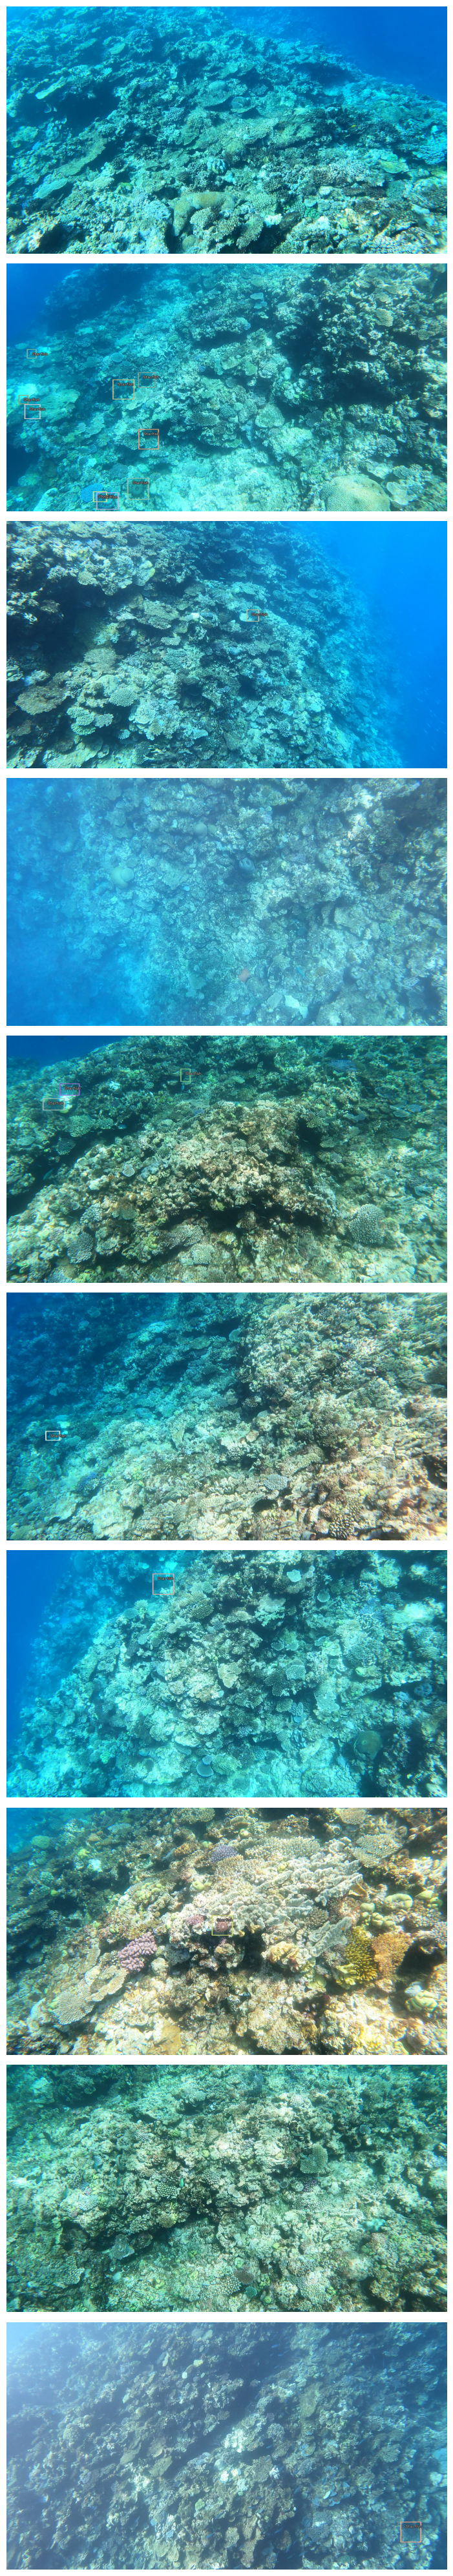

In [75]:
show_records(train_records[:10], display_label=True, display_bbox=True, figsize=(30,40))

### Model training

In [25]:
presize = 720
size = 832

In [26]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, 
                                              presize=presize),
                             tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [27]:
# model_type = models.torchvision.retinanet
# backbone = model_type.backbones.resnet34_fpn

# model = model_type.model(backbone=backbone(pretrained=True), 
#                          num_classes=len(parser.class_map))

model_type = models.ultralytics.yolov5
# backbone = model_type.backbones.large_p6
backbone = model_type.backbones.extra_large_p6

model = model_type.model(backbone=backbone(pretrained=True), 
                         num_classes=len(parser.class_map),
                         img_size=size)

train_dl = model_type.train_dl(train_ds, batch_size=3, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=3, num_workers=4, shuffle=False)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(valley=0.17378008365631104)

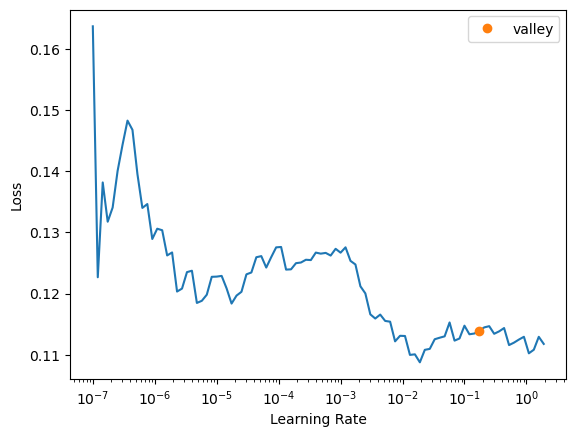

In [198]:
learn.freeze()
# learn.lr_find(end_lr=4e-3, stop_div=False)
learn.lr_find()

### yolov5 extra_large_p6

negative_examples_frac = 1.0
sample_frac = 1.0
size=size, 
presize=presize, 
shift_scale_rotate=None,
blur=None,
lightning=None,
rgb_shift=None)

In [27]:
MODEL_FILE = f'../../../models/yolov5_extra_large_p6_lr_8.0e-3_sequence_split_1.0_samplefrac_1_10_epochs.pth'

model_type = models.ultralytics.yolov5
# backbone = model_type.backbones.large_p6
backbone = model_type.backbones.extra_large_p6

model = model_type.model(backbone=backbone(pretrained=True), 
                         num_classes=len(parser.class_map),
                         img_size=size)

state_dict = torch.load(MODEL_FILE, map_location=torch.device('cuda')) 

model.load_state_dict(state_dict)

model = model.cuda(0)

train_dl = model_type.train_dl(train_ds, batch_size=3, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=3, num_workers=4, shuffle=False)

metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

Second round of training

In [28]:
learn.fine_tune(10, 8.0e-3, freeze_epochs=0)

In [29]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map, thr_step=0.01)

  0%|          | 0/1898 [00:00<?, ?it/s]

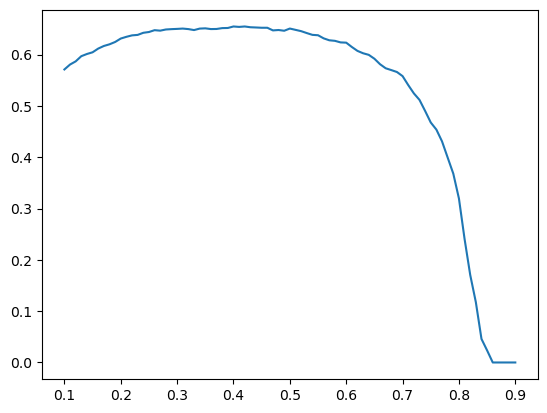

In [30]:
plt.plot(thrs, f2s)

First round of training

In [28]:
learn.fine_tune(10, 8.0e-3, freeze_epochs=1)

In [29]:
# Save trained weights in a local folder
torch.save(model.state_dict(), 
           f'../../../models/yolov5_extra_large_p6_lr_8.0e-3_sequence_split_1.0_samplefrac_1_10_epochs.pth')

In [35]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map, thr_step=0.01)

  0%|          | 0/1898 [00:00<?, ?it/s]

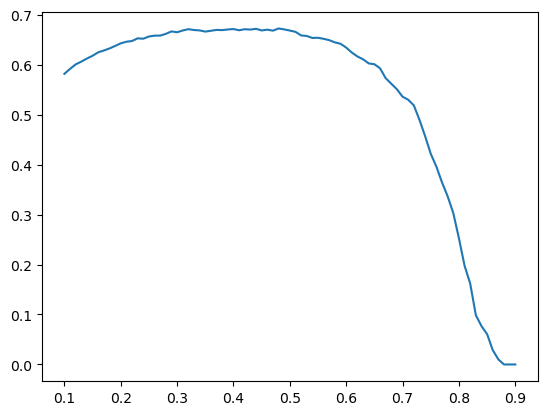

In [36]:
plt.plot(thrs, f2s)

### yolov5 extra_large_p6

negative_examples_frac = 1.0
sample_frac = 0.1
size=size, 
presize=presize, 
shift_scale_rotate=None,
blur=None,
lightning=None,
rgb_shift=None)

In [28]:
learn.fine_tune(10, 1.6e-2, freeze_epochs=1)

In [28]:
learn.fine_tune(10, 8.0e-3, freeze_epochs=1)

In [42]:
learn.fine_tune(10, 4.0e-3, freeze_epochs=1)

In [43]:
# Save trained weights in a local folder
torch.save(model.state_dict(), 
           f'../../../models/yolov5_extra_large_p6_lr_4.0e-3_sequence_split_0.1_samplefrac_1_10_epochs.pth')

In [44]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map)

  0%|          | 0/189 [00:00<?, ?it/s]

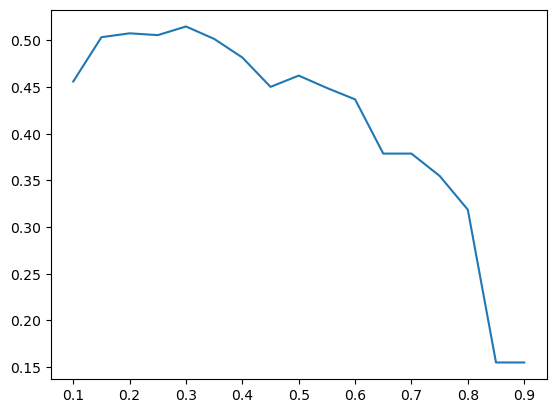

In [45]:
plt.plot(thrs, f2s)

In [37]:
learn.fine_tune(10, 2.0e-3, freeze_epochs=1)

In [38]:
# Save trained weights in a local folder
torch.save(model.state_dict(), 
           f'../../../models/yolov5_extra_large_p6_lr_2.0e-3_sequence_split_0.1_samplefrac_1_10_epochs.pth')

In [39]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map)

  0%|          | 0/189 [00:00<?, ?it/s]

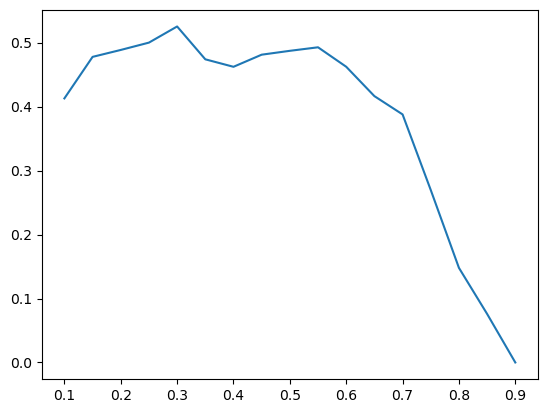

In [40]:
plt.plot(thrs, f2s)

In [28]:
learn.fine_tune(10, 1.0e-3, freeze_epochs=1)

In [29]:
# Save trained weights in a local folder
torch.save(model.state_dict(), 
           f'../../../models/yolov5_extra_large_p6_lr_1.0e-3_sequence_split_0.1_samplefrac_1_10_epochs.pth')

In [30]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map)

  0%|          | 0/189 [00:00<?, ?it/s]

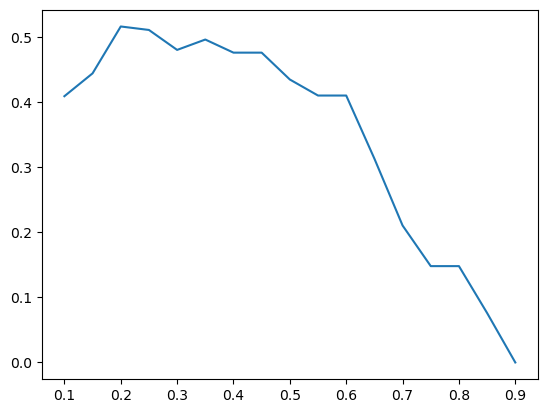

In [31]:
plt.plot(thrs, f2s)

### yolov5 large_p6

negative_examples_frac = 1.0
sample_frac = 0.1
size=size, 
presize=presize, 
shift_scale_rotate=None,
blur=None,
lightning=None,
rgb_shift=None)

In [33]:
learn.fine_tune(10, 1.0e-3, freeze_epochs=1)

In [34]:
thrs, f2s = compute_f2(model_type, model, valid_ds, valid_tfms, parser.class_map)

  0%|          | 0/189 [00:00<?, ?it/s]

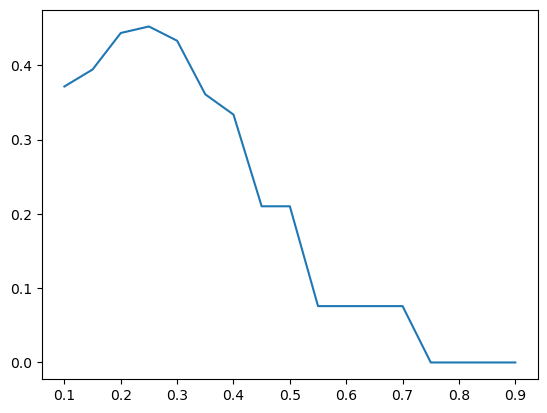

In [35]:
plt.plot(thrs, f2s)

### Attempt to load the sample

In [1]:
import sys

src_dir = '../../../data'
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
from PIL import Image
from icevision.all import *

import greatbarrierreef

env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission

In [28]:
cmp = ClassMap(['starfish'])
size = 832

MODEL_FILE = f'../../../models/yolov5_extra_large_p6_lr_8.0e-3_sequence_split_1.0_samplefrac_1_10_epochs.pth'

model_type = models.ultralytics.yolov5
backbone = model_type.backbones.extra_large_p6

model = model_type.model(backbone=backbone(pretrained=True), 
                         num_classes=len(cmp),
                         img_size=size)

state_dict = torch.load(MODEL_FILE, map_location=torch.device('cuda')) 

model.load_state_dict(state_dict)
model = model.cuda(0)

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [4]:
# tst = list(iter_test)
thr = 0.45

for (pixel_array, sample_prediction_df) in iter_test:
    p = model_type.end2end_detect(Image.fromarray(pixel_array), 
                                  valid_tfms, 
                                  model, 
                                  class_map=cmp, 
                                  detection_threshold=0.1)
    
    curr_bboxes = p['detection']['bboxes']
    curr_scores = p['detection']['scores']
    
    output_boxes = []
    

    for i, _ in enumerate(curr_bboxes):
        if curr_scores[i] > thr:
            xmin, ymin, width, height = curr_bboxes[i].xywh
            output_boxes.append(f'{curr_scores[i]} {xmin} {ymin} {width} {height}')

    output_boxes = ' '.join(output_boxes)
    
    sample_prediction_df['annotations'] = output_boxes  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


/home/chris/apps/miniconda3/envs/icevision37/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Scratch work

In [35]:
pixel_array.shape

(720, 1280, 3)

In [36]:
img = Image.open('../../../data/train_images/video_0/0.jpg')

In [39]:
img.shape

(720, 1280)

In [40]:
img.close()

In [48]:
p = model_type.end2end_detect(Image.fromarray(pixel_array), valid_tfms, model, class_map=parser.class_map, detection_threshold=0.1)

In [72]:
p

{'detection': {'scores': array([], dtype=float32),
  'bboxes': [],
  'labels': [],
  'label_ids': []},
 'img': <PIL.Image.Image image mode=RGB size=1280x720 at 0x7F0A74170B10>,
 'width': 720,
 'height': 1280}

In [76]:
detection_threshold = 0.1
preds = []

for entry in tqdm(valid_ds.records[:30]):
    img = Image.open(entry.filepath)

    pred = model_type.end2end_detect(img, 
                                    valid_tfms, 
                                    model, 
                                    class_map=parser.class_map, 
                                    detection_threshold=detection_threshold)
    preds.append(pred)

    img.close()

  0%|          | 0/30 [00:00<?, ?it/s]

In [77]:
curr_bboxes = preds[3]['detection']['bboxes']
curr_scores = preds[3]['detection']['scores']

curr_bboxes, curr_scores

preds[3]

{'detection': {'labels': ['starfish', 'starfish', 'starfish', 'starfish'],
  'label_ids': [1, 1, 1, 1],
  'bboxes': [<BBox (xmin:333, ymin:378, xmax:378, ymax:423)>,
   <BBox (xmin:627, ymin:520, xmax:666, ymax:556)>,
   <BBox (xmin:475, ymin:83, xmax:509, ymax:109)>,
   <BBox (xmin:503, ymin:63, xmax:533, ymax:93)>],
  'scores': array([    0.23369,     0.23357,     0.17677,     0.12719], dtype=float32)},
 'img': <PIL.Image.Image image mode=RGB size=1280x720 at 0x7F25C1545090>,
 'width': 720,
 'height': 1280}

In [78]:
valid_ds[3]

BaseRecord

common: 
	- Record ID: 2_4723
	- Filepath: ../../../data/train_images/video_2/4723.jpg
	- Img: 832x832x3 <np.ndarray> Image
	- Image size ImgSize(width=832, height=832)
detection: 
	- Class Map: <ClassMap: {'background': 0, 'starfish': 1}>
	- Labels: [1]
	- BBoxes: [<BBox (xmin:133.9, ymin:523.9, xmax:154.04999999999998, ymax:547.95)>]

In [80]:
model.

yolov5.models.yolo.Model

In [70]:
output_boxes = []
thr = 0.1

for i, _ in enumerate(curr_bboxes):
    if curr_scores[i] > thr:
        xmin, ymin, width, height = curr_bboxes[i].xywh
        output_boxes.append(f'{curr_scores[i]} {xmin} {ymin} {width} {height}')
        
output_boxes = ' '.join(output_boxes)
#         curr_bboxes

In [71]:
output_boxes

'0.3935861587524414 313 381 48 48 0.10903383046388626 613 540 36 35'

In [84]:
m = torch.load(open('../../../models/yolov5x6.pt', 'rb'))

In [85]:
type(m)

dict

In [86]:
m

{'epoch': -1,
 'best_fitness': array([    0.55389]),
 'model': Model(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 80, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
       (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU()
     )
     (1): Conv(
       (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU()
     )
     (2): C3(
       (cv1): Conv(
         (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU()
       )
       (cv2): Conv(
         (conv): Conv2d(160, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
     